# I. Import and clean data set

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Let's check the used GPU and all the file name in my Drive
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'- Found GPU at: {device_name}\n')

print('- My Drive:')
!ls "/content/drive/My Drive/"

- Found GPU at: /device:GPU:0

- My Drive:
'Agenda 2021.gsheet'  'Colab Notebooks'		 P8_kaggle
 Analyses	       P6_Image_Classification	 Projet_6_Image_Classification
 app		       P7_POC			 Thèse


In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import gensim
import nltk
from gensim.utils import simple_preprocess
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS

# Download wordnet and stopwords
nltk.download('wordnet')
nltk.download('stopwords')


# Figures parameters
sns.set()
plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style('whitegrid')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Import Datasets
path = "/content/drive/My Drive/P7_POC/QueryResults_with_text.csv"
data_stackoverflow = pd.read_csv(path, low_memory=False, encoding='latin-1')

# Keep the questions with Views >30.
data_stackoverflow = data_stackoverflow[data_stackoverflow['ViewCount']>=30]
df_sample = data_stackoverflow.iloc[:,[-4, -3, -1]].reset_index().drop(['index'], axis=1)

# Remove punctuation
df_sample['Title'] = df_sample['Title'].map(lambda x: re.sub('[,\.!?]<>-', ' ', x))
df_sample['Body'] = df_sample['Body'].map(lambda x: re.sub('[,\.!?]<>-', ' ', x))
df_sample['Tags'] = df_sample['Tags'].map(lambda x: re.sub('[<>]', ' ', x))

# Remove Stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'without', 'way', 'subject', 're', 'edu', 'be', 'have', 'do', 'say', 
                   'get', 'make', 'go', 'know', 'take', 'see', 'come', 'think', 
                   'look', 'want', 'give', 'use', 'find', 'tell', 'ask', 'work',
                   'seem', 'feel', 'try', 'leave', 'call'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(df_sample['Title'])
data_body_nostops = remove_stopwords(df_sample['Body'])

# Data shaping for the analysis
Texts = []
for i in data_words_nostops:
    Texts.append(' '.join(map(str, i)))

Body = []
for i in data_body_nostops:
    Body.append(' '.join(map(str, i)))


mydata = pd.DataFrame()
mydata['Title'], mydata['Body'], mydata['Tags'] = Texts, Body, df_sample['Tags']
mydata["Title_Body"] = mydata[["Title", "Body"]].agg(' '.join, axis=1) # add the content of the columns Tittle to the content of Body with a space (" ") as seperator
mydata.head()

,Title,Body,Tags,Title_Body
0,net system text json configure frombody avoid ...,migrating project code microsoft aspnetcore mv...,c# json .net system.text.json .net-5,net system text json configure frombody avoid ...
1,create video meeting teams microsoft com,might rather basic seems like simplest possibl...,microsoft-graph-api microsoft-teams microso...,create video meeting teams microsoft com might...
2,addscoped dependency,net core dependency scoped rest api request ad...,c# asp.net-core .net-core dependency-injec...,addscoped dependency net core dependency scope...
3,actix web mongodb project fails build async mo...,implementing rest api using actix web mongodb ...,linux mongodb rust actix-web,actix web mongodb project fails build async mo...
4,perform bulkwrite mongodb using rust mongodb d...,implementing process rust read large number do...,mongodb rust,perform bulkwrite mongodb using rust mongodb d...


In [ ]:
# Extract the 200 most frequent tags

# Convert the text in tags into a list of words
mydata['Tags_list'] = mydata.Tags.apply(lambda x: x[:].split(' '))


# Select the 200 most frequent words in tags
Most_freq = pd.Series(' '.join(mydata['Tags']).split()).value_counts()[:200].index


# Add the 200 most frequent tags to all the row of mydata
Most_freq_tags=[]
for i in range(0, len(Most_freq)):
    Most_freq_tags.append(Most_freq[i])

mydata['Most_freq_tags'] = pd.Series([Most_freq_tags for x in range(len(mydata.index))]) # Add the list to all the row


# For each question search the common tags between the Stack Overflow Tags and the list of the most frequent tags of the dataframe
# By doing this I keep only the tags that figure in the lise of the most frequent ones.
common_tags = []
for i in range(0,len(mydata)):
    List_tags = mydata['Tags_list'][i]
    Frequent_tags = mydata['Most_freq_tags'][i]
    common_tags.append([x for x in Frequent_tags if x in List_tags])

mydata['Common_tags'] = common_tags # Add the Common_tags to mydata


# Convert the list of Common tags into Text
Tags_final = []

for i in mydata['Common_tags']:
    Tags_final.append(' '.join(map(str, i)))
mydata['Tags_final'] = Tags_final


# Columns selection for modeling
mydata = mydata.loc[:, ['Title', 'Body', 'Title_Body', 'Common_tags', 'Tags_final']]
mydata.head()

,Title,Body,Title_Body,Common_tags,Tags_final
0,net system text json configure frombody avoid ...,migrating project code microsoft aspnetcore mv...,net system text json configure frombody avoid ...,"[c#, .net, json, .net-5]",c# .net json .net-5
1,create video meeting teams microsoft com,might rather basic seems like simplest possibl...,create video meeting teams microsoft com might...,[microsoft-graph-api],microsoft-graph-api
2,addscoped dependency,net core dependency scoped rest api request ad...,addscoped dependency net core dependency scope...,"[c#, asp.net-core, .net-core, dependency-injec...",c# asp.net-core .net-core dependency-injection
3,actix web mongodb project fails build async mo...,implementing rest api using actix web mongodb ...,actix web mongodb project fails build async mo...,"[linux, rust, mongodb]",linux rust mongodb
4,perform bulkwrite mongodb using rust mongodb d...,implementing process rust read large number do...,perform bulkwrite mongodb using rust mongodb d...,"[rust, mongodb]",rust mongodb


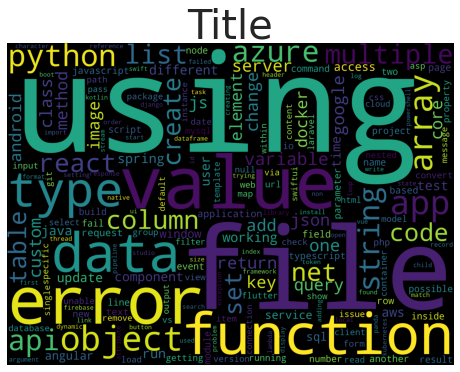

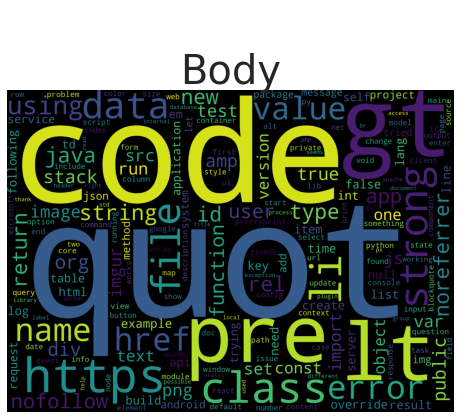

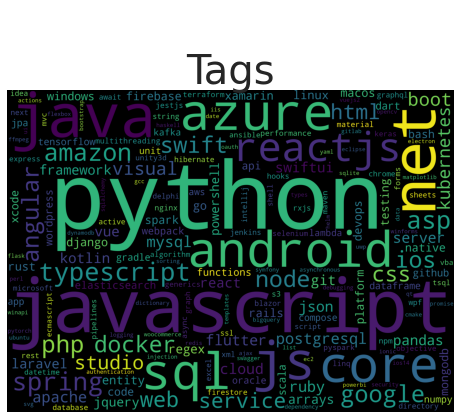

In [ ]:
# WordCloud of the words in the title and the tags after processing

for i,j in zip([mydata.Title, mydata.Body, mydata.Tags_final], ["Title", "\nBody","\nTags"]):
    plt.figure(figsize=(8,6))
    text = i.values
    cloud_toxic = WordCloud(stopwords=STOPWORDS, background_color='black', collocations=False,
                              width=2500, height=1800).generate(" ".join(text))
    
    plt.axis('off')
    plt.title(j, fontsize=40)
    plt.imshow(cloud_toxic)

# II. Baseline SGDClassifier (with Tfidf)

### II.0. Required libraries

In [ ]:
# Install the required libraries
!pip install scikit-multilearn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection.iterative_stratification import IterativeStratification
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.ticker import PercentFormatter
from io import StringIO
import timeit

     |████████████████████████████████| 89 kB 3.8 MB/s 


### II.1. SGDClassifier trained on Title 

In [ ]:
# Define X
tfidf_vectorizer = TfidfVectorizer(min_df=3, # ignores terms whose document frequency is less than 3
                                    max_df=0.85, # ignores terms whose document frequency is greater than 85%
                                    ngram_range=(1,1) # it allows us to choose a range of word lengths, I’m sticking with 1 word
                                    )
X_tfidf = tfidf_vectorizer.fit_transform(mydata['Title'].tolist())


# Define Y by converting the multi-label classification to a binary output
Tags = mydata['Common_tags']
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(mydata['Common_tags'])

In [ ]:
# Split X and Y to train and test set
stratifier = IterativeStratification(n_splits=2, order=2, 
                                     sample_distribution_per_fold=[1.0 - 0.7, 0.7]) # this class is a generator that produces k-folds.
                                                                                    # We just want to iterate it once to make a single static split
                                                                                    # NOTE: needs to be computed on hard labels.
train_indexes, test_indexes = next(stratifier.split(X=X_tfidf, y=Y))

# text array shape (N_samp,)
x_train_tfidf, x_test_tfidf = X_tfidf[train_indexes], X_tfidf[test_indexes]

# labels array shape (N_samp, n_classes)
y_train_tfidf, y_test_tfidf = Y[train_indexes, :], Y[test_indexes, :]

print('x_train', x_train_tfidf.shape,'\n', 'y_train', y_train_tfidf.shape, '\n')
print('x_test', x_test_tfidf.shape, '\n' , 'y_test', y_test_tfidf.shape)

x_train (32533, 7575) 
 y_train (32533, 200) 

x_test (13943, 7575) 
 y_test (13943, 200)


In [ ]:
start_time = timeit.default_timer()
# Define model
SGDC = SGDClassifier() # loss= Defaults to ‘hinge’, which gives a linear SVM.
SGDC_onevsrest = OneVsRestClassifier(SGDC)

# Hyperparemeter tunning
grid= {'estimator__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]} # learning rate
score = 'accuracy' # define the scoring 
logSDGC = GridSearchCV(SGDC_onevsrest, grid, cv=10, scoring=score) # GridSearch

# Fit the model
logSDGC.fit(x_train_tfidf, y_train_tfidf)
print('tuned hpyerparameters :(best parameters)', logSDGC.best_params_) # Print best the best parametres


# Final model
SGDC = SGDClassifier(alpha=logSDGC.best_params_['estimator__alpha'])
SGDC_onevsrest = OneVsRestClassifier(SGDC)

# Fit the model
SGDC_onevsrest.fit(x_train_tfidf, y_train_tfidf)

# Predict on test set
y_pred = SGDC_onevsrest.predict(x_test_tfidf)

elapsed = timeit.default_timer() - start_time

print('Accuracy:', accuracy_score(y_test_tfidf, y_pred))
print(f"Time: {round(elapsed/60,0)} min")

tuned hpyerparameters :(best parameters) {'estimator__alpha': 0.0001}
Accuracy: 0.30732267087427384
Time: 6.0 min


In [ ]:
model_=[]
acc_=[]
time_=[]

model_.append('SGDC_Title')
acc_.append(round(accuracy_score(y_test_tfidf, y_pred),3))
time_.append(round(elapsed/60,0))

df = pd.DataFrame()
df['Model'], df['Accuracy'], df['Time(min)'] = model_, acc_, time_
df

,Model,Accuracy,Time (min)
0,SGDC_Title,0.307,6.0


### II.2. SGDClassifier trained on Body

In [ ]:
# Define X
tfidf_vectorizer = TfidfVectorizer(min_df=3, # ignores terms whose document frequency is less than 3
                                    max_df=0.85, # ignores terms whose document frequency is greater than 85%
                                    ngram_range=(1,1) # it allows us to choose a range of word lengths, I’m sticking with 1 word
                                    )
X_tfidf = tfidf_vectorizer.fit_transform(mydata['Body'].tolist())


# Define Y by converting the multi-label classification to a binary output
Tags = mydata['Common_tags']
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(mydata['Common_tags'])

In [ ]:
# Split X and Y to train and test set
stratifier = IterativeStratification(n_splits=2, order=2, 
                                     sample_distribution_per_fold=[1.0 - 0.7, 0.7]) # this class is a generator that produces k-folds.
                                                                                    # We just want to iterate it once to make a single static split
                                                                                    # NOTE: needs to be computed on hard labels.
train_indexes, test_indexes = next(stratifier.split(X=X_tfidf, y=Y))

# text array shape (N_samp,)
x_train_tfidf, x_test_tfidf = X_tfidf[train_indexes], X_tfidf[test_indexes]

# labels array shape (N_samp, n_classes)
y_train_tfidf, y_test_tfidf = Y[train_indexes, :], Y[test_indexes, :]

print('x_train', x_train_tfidf.shape,'\n', 'y_train', y_train_tfidf.shape, '\n')
print('x_test', x_test_tfidf.shape, '\n' , 'y_test', y_test_tfidf.shape)

x_train (32533, 38273) 
 y_train (32533, 200) 

x_test (13943, 38273) 
 y_test (13943, 200)


In [ ]:
start_time = timeit.default_timer()
# Define model
SGDC = SGDClassifier() # loss= Defaults to ‘hinge’, which gives a linear SVM.
SGDC_onevsrest = OneVsRestClassifier(SGDC)

# Hyperparemeter tunning
grid= {'estimator__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]} # learning rate
score = 'accuracy' # define the scoring 
logSDGC = GridSearchCV(SGDC_onevsrest, grid, cv=10, scoring=score) # GridSearch

# Fit the model
logSDGC.fit(x_train_tfidf, y_train_tfidf)
print('tuned hpyerparameters :(best parameters)', logSDGC.best_params_) # Print best the best parametres


# Final model
SGDC = SGDClassifier(alpha=logSDGC.best_params_['estimator__alpha'])
SGDC_onevsrest = OneVsRestClassifier(SGDC)

# Fit the model
SGDC_onevsrest.fit(x_train_tfidf, y_train_tfidf)

# Predict on test set
y_pred = SGDC_onevsrest.predict(x_test_tfidf)

elapsed = timeit.default_timer() - start_time

print('Accuracy:', accuracy_score(y_test_tfidf, y_pred))
print(f"Time: {round(elapsed/60,0)} min")

tuned hpyerparameters :(best parameters) {'estimator__alpha': 0.0001}
Accuracy: 0.26486408950727963
Time: 21.0 min


In [ ]:
model_.append('SGDC_Body')
acc_.append(round(accuracy_score(y_test_tfidf, y_pred),3))
time_.append(round(elapsed/60,0))

df = pd.DataFrame()
df['Model'], df['Accuracy'], df['Time(min)'] = model_, acc_, time_
df

,Model,Accuracy,Time(min)
0,SGDC_Title,0.307,6.0
1,SGDC_Body,0.265,21.0


### II.3. SGDClassifier trained on Body + Title

In [ ]:
# Define X
tfidf_vectorizer = TfidfVectorizer(min_df=3, # ignores terms whose document frequency is less than 3
                                    max_df=0.85, # ignores terms whose document frequency is greater than 85%
                                    ngram_range=(1,1) # it allows us to choose a range of word lengths, I’m sticking with 1 word
                                    )
X_tfidf = tfidf_vectorizer.fit_transform(mydata['Title_Body'].tolist())


# Define Y by converting the multi-label classification to a binary output
Tags = mydata['Common_tags']
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(mydata['Common_tags'])

In [ ]:
# Split X and Y to train and test set
stratifier = IterativeStratification(n_splits=2, order=2, 
                                     sample_distribution_per_fold=[1.0 - 0.7, 0.7]) # this class is a generator that produces k-folds.
                                                                                    # We just want to iterate it once to make a single static split
                                                                                    # NOTE: needs to be computed on hard labels.
train_indexes, test_indexes = next(stratifier.split(X=X_tfidf, y=Y))

# text array shape (N_samp,)
x_train_tfidf, x_test_tfidf = X_tfidf[train_indexes], X_tfidf[test_indexes]

# labels array shape (N_samp, n_classes)
y_train_tfidf, y_test_tfidf = Y[train_indexes, :], Y[test_indexes, :]

print('x_train', x_train_tfidf.shape,'\n', 'y_train', y_train_tfidf.shape, '\n')
print('x_test', x_test_tfidf.shape, '\n' , 'y_test', y_test_tfidf.shape)

x_train (32533, 38653) 
 y_train (32533, 200) 

x_test (13943, 38653) 
 y_test (13943, 200)


In [ ]:
start_time = timeit.default_timer()
# Define model
SGDC = SGDClassifier() # loss= Defaults to ‘hinge’, which gives a linear SVM.
SGDC_onevsrest = OneVsRestClassifier(SGDC)

# Hyperparemeter tunning
grid= {'estimator__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]} # learning rate
score = 'accuracy' # define the scoring 
logSDGC = GridSearchCV(SGDC_onevsrest, grid, cv=10, scoring=score) # GridSearch

# Fit the model
logSDGC.fit(x_train_tfidf, y_train_tfidf)
print('tuned hpyerparameters :(best parameters)', logSDGC.best_params_) # Print best the best parametres


# Final model
SGDC = SGDClassifier(alpha=logSDGC.best_params_['estimator__alpha'])
SGDC_onevsrest = OneVsRestClassifier(SGDC)

# Fit the model
SGDC_onevsrest.fit(x_train_tfidf, y_train_tfidf)

# Predict on test set
y_pred = SGDC_onevsrest.predict(x_test_tfidf)

elapsed = timeit.default_timer() - start_time

print('Accuracy:', accuracy_score(y_test_tfidf, y_pred))
print(f"Time: {round(elapsed/60,0)} min")

tuned hpyerparameters :(best parameters) {'estimator__alpha': 0.0001}
Accuracy: 0.2949867316933228
Time: 23.0 min


In [ ]:
model_=['SGDC_Title', 'SGDC_Body']
acc_=[0.307, 0.265]
time_=[6.0, 21.0]

In [ ]:
model_.append('SGDC_Title&Body')
acc_.append(round(accuracy_score(y_test_tfidf, y_pred),3))
time_.append(round(elapsed/60,0))

df = pd.DataFrame()
df['Model'], df['Accuracy'], df['Time(min)'] = model_, acc_, time_
df

,Model,Accuracy,Time(min)
0,SGDC_Title,0.307,6.0
1,SGDC_Body,0.265,21.0
2,SGDC_Title&Body,0.295,23.0


### II.4. SGDClassifier trained on Body + Title and tested on Title

In [ ]:
# Import new dataset

# Import Datasets
path = "/content/drive/My Drive/P7_POC/QueryResults_for_test.csv"
data_stackoverflow = pd.read_csv(path, low_memory=False, encoding='latin-1')

# Keep the questions with Views >30.
data_stackoverflow = data_stackoverflow[data_stackoverflow['ViewCount']>=30]

df_sample = data_stackoverflow.iloc[:,[-5, -6]].reset_index().drop(['index'], axis=1)

# Remove punctuation
df_sample['Title'] = df_sample['Title'].map(lambda x: re.sub('[,\.!?]<>-', ' ', x))
df_sample['Tags'] = df_sample['Tags'].map(lambda x: re.sub('[<>]', ' ', x))

stop_words = stopwords.words('english')
stop_words.extend(['from', 'without', 'way', 'subject', 're', 'edu', 'be', 'have', 'do', 'say', 
                   'get', 'make', 'go', 'know', 'take', 'see', 'come', 'think', 
                   'look', 'want', 'give', 'use', 'find', 'tell', 'ask', 'work',
                   'seem', 'feel', 'try', 'leave', 'call'])

# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(df_sample['Title'])

# Data shaping for the analysis
Texts = []
for i in data_words_nostops:
    Texts.append(' '.join(map(str, i)))

# Create the data on which I will do the analysis
mydata = pd.DataFrame()

mydata['Title'], mydata['Tags'] = Texts, df_sample['Tags']
mydata.head()

,Title,Tags
0,puppeteer objects within test,node.js sapui5 puppeteer karma-runner
1,jq modify else working,jq
2,remove layer aws lambda function,amazon-web-services aws-lambda aws-sdk aws...
3,local system fonts wkhtml pdf pre tags,css fonts wkhtml2pdf
4,sql server optimizing common table expression,sql sql-server


In [ ]:
# Extract the 200 most frequent tags

# Convert the text in tags into a list of words
mydata['Tags_list'] = mydata.Tags.apply(lambda x: x[:].split(' '))


# Select the 200 most frequent words in tags
Most_freq = pd.Series(' '.join(mydata['Tags']).split()).value_counts()[:200].index


# Add the 200 most frequent tags to all the row of mydata
Most_freq_tags=[]
for i in range(0, len(Most_freq)):
    Most_freq_tags.append(Most_freq[i])

mydata['Most_freq_tags'] = pd.Series([Most_freq_tags for x in range(len(mydata.index))]) # Add the list to all the row


# For each question search the common tags between the Stack Overflow Tags and the list of the most frequent tags of the dataframe
# By doing this I keep only the tags that figure in the lise of the most frequent ones.
common_tags = []
for i in range(0,len(mydata)):
    List_tags = mydata['Tags_list'][i]
    Frequent_tags = mydata['Most_freq_tags'][i]
    common_tags.append([x for x in Frequent_tags if x in List_tags])

mydata['Common_tags'] = common_tags # Add the Common_tags to mydata


# Convert the list of Common tags into Text
Tags_final = []

for i in mydata['Common_tags']:
    Tags_final.append(' '.join(map(str, i)))
mydata['Tags_final'] = Tags_final


# Columns selection for modeling
mydata = mydata.loc[:, ['Title', 'Common_tags', 'Tags_final']]
mydata.head()

,Title,Common_tags,Tags_final
0,puppeteer objects within test,[node.js],node.js
1,jq modify else working,[],
2,remove layer aws lambda function,"[amazon-web-services, aws-lambda]",amazon-web-services aws-lambda
3,local system fonts wkhtml pdf pre tags,[css],css
4,sql server optimizing common table expression,"[sql, sql-server]",sql sql-server


In [ ]:
# Define X
X_tfidf = tfidf_vectorizer.transform(mydata['Title'].tolist())

# Define Y by converting the multi-label classification to a binary output
Y = mlb.fit_transform(mydata['Common_tags'])

In [ ]:
# Split X and Y to train and test set
stratifier = IterativeStratification(n_splits=2, order=2, 
                                     sample_distribution_per_fold=[1.0 - 0.7, 0.7]) # this class is a generator that produces k-folds.
                                                                                    # We just want to iterate it once to make a single static split
                                                                                    # NOTE: needs to be computed on hard labels.
train_indexes, test_indexes = next(stratifier.split(X=X_tfidf, y=Y))

# text array shape (N_samp,)
x_new, x_test_tfidf_new = X_tfidf[train_indexes], X_tfidf[test_indexes]

# labels array shape (N_samp, n_classes)
y_new, y_test_tfidf_new = Y[train_indexes, :], Y[test_indexes, :]

print('x_train', x_new.shape,'\n', 'y_train', y_new.shape, '\n')
print('x_test', x_test_tfidf_new.shape, '\n' , 'y_test', y_test_tfidf_new.shape)

x_train (15150, 38653) 
 y_train (15150, 200) 

x_test (6494, 38653) 
 y_test (6494, 200)


In [ ]:
# Predict the last model trained on Body + Title and tested on Titles of a new data set
y_pred_new = SGDC_onevsrest.predict(x_new)

print('Accuracy:', accuracy_score(y_new, y_pred_new))

Accuracy: 0.10600660066006601


In [ ]:
model_.append('SGDC_test_Title')
acc_.append(round(accuracy_score(y_new, y_pred_new),3))
time_.append(23.0) # as the one before. It's the same training

df = pd.DataFrame()
df['Model'], df['Accuracy'], df['Time(min)'] = model_, acc_, time_
df

,Model,Accuracy,Time(min)
0,SGDC_Title,0.307,6.0
1,SGDC_Body,0.265,21.0
2,SGDC_Title&Body,0.295,23.0
3,SGDC_Title&Body/test_Title,0.106,23.0


### II.5. Figure showing the performance in terms of time and accuracy of each of the SGDClassifier models

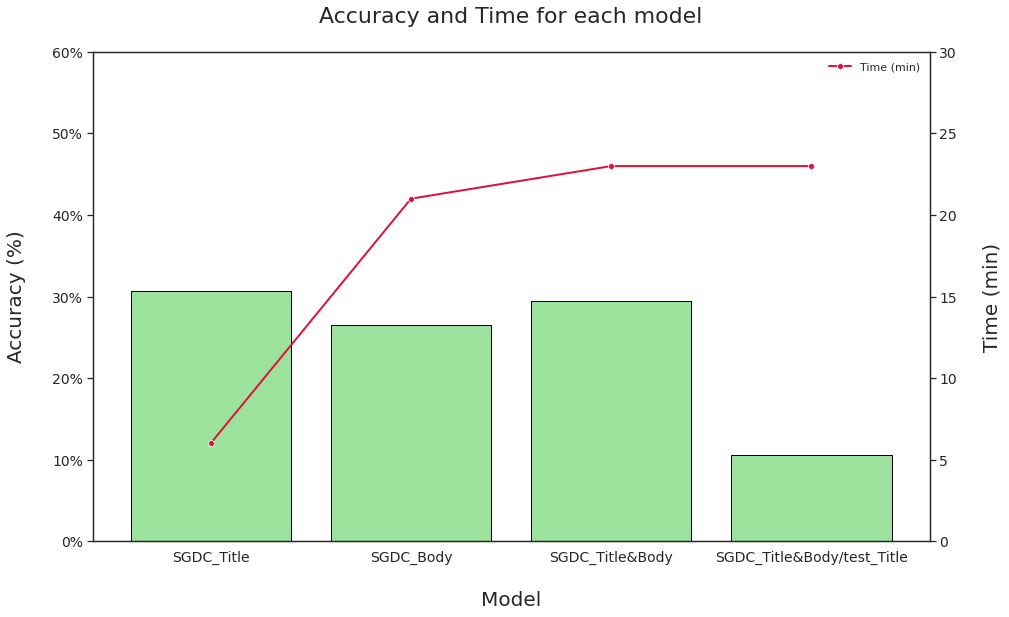

In [ ]:
plt.figure(figsize=(15, 9))
sns.set_theme(style="white")

x_ = df.columns[0]
y_ = df.columns[1]
y_2 = df.columns[2]
data1 = df[[x_, y_]]
data2 = df[[x_, y_2]]

ax = sns.barplot(x=x_, y=y_, data=data1, edgecolor="black", color='lightgreen')
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_ylim([0,0.6])
ax.set_xlabel("\nModel", fontsize=20)
ax.set_ylabel("Accuracy (%)\n", fontsize=20)
ax.set_title("Accuracy and Time for each model\n", fontsize=22)

ax2 = ax.twinx()
p = sns.lineplot(x=x_, y=y_2, data=data2, marker='o', color='crimson', lw=2, ax=ax2)
p.set_ylim([0,30])
p.tick_params(axis = 'both', labelsize = 14)
p.set_ylabel("\nTime (min)", fontsize=20)

plt.legend(labels=["Time (min)"], loc = 1)


# III. Convolutional Neural Network (Word embedding)

### III.0. Required libraries

In [ ]:
# Install the required libraries
!pip install scikit-multilearn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
import timeit
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection.iterative_stratification import IterativeStratification
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, Flatten, Dropout, Dense 
from tensorflow import keras
from matplotlib.ticker import PercentFormatter

### III.1. Word embedding (Deep learning) trained on Title

In [ ]:
# Clean data
mydata['text_clean'] = mydata['Title'].apply(lambda x: gensim.utils.simple_preprocess(x))

## Text encoding
def process_text(data):
    tokenizer = Tokenizer(num_words=5000, oov_token='<UNK>') # Tokenize text
    tokenizer.fit_on_texts(data)

    word_index = tokenizer.word_index # get word index
    vocab_size = len(tokenizer.word_index) + 1 # get the length of the vocabulary 

    sequences = tokenizer.texts_to_sequences(data) # Encode text into sequences
    maxlen = max([len(x) for x in sequences]) # Get the maximun lenth of sequence
    
    padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=maxlen) # Pad the sequences to the same lenth
    return word_index, sequences, maxlen, padded, vocab_size

text_processed = process_text(list(mydata['text_clean']))

## Print result of text encoding
print(f"- Shape : {text_processed[3].shape}")
print(f"- Maximum lenth of sequence : {text_processed[2]}")
print(f"- Vocabulary size : {text_processed[4]}")
print(f"- Type of sequences : {type(text_processed[1])}")
print(f"- Padding type : {type(text_processed[3])}")

print(f"\n- All words index :\n{text_processed[0]}\n")
print(f"- Word index of a sequence :\n{list(mydata['text_clean'])[0]}")
print(f"{text_processed[1][0]}")
print(f"- Padded text of the same sequence:\n{text_processed[3][0]}\n")

- Shape : (46476, 19)
- Maximum lenth of sequence : 19
- Vocabulary size : 21319
- Type of sequences : <class 'list'>
- Padding type : <class 'numpy.ndarray'>

- All words index :
{'<UNK>': 1, 'using': 2, 'error': 3, 'file': 4, 'data': 5, 'function': 6, 'value': 7, 'type': 8, 'python': 9, 'app': 10, 'azure': 11, 'array': 12, 'api': 13, 'multiple': 14, 'string': 15, 'object': 16, 'react': 17, 'list': 18, 'net': 19, 'code': 20, 'create': 21, 'set': 22, 'one': 23, 'server': 24, 'google': 25, 'custom': 26, 'query': 27, 'class': 28, 'json': 29, 'add': 30, 'core': 31, 'android': 32, 'values': 33, 'table': 34, 'js': 35, 'working': 36, 'docker': 37, 'java': 38, 'column': 39, 'spring': 40, 'aws': 41, 'different': 42, 'angular': 43, 'run': 44, 'access': 45, 'sql': 46, 'files': 47, 'method': 48, 'update': 49, 'application': 50, 'text': 51, 'variable': 52, 'cannot': 53, 'javascript': 54, 'image': 55, 'change': 56, 'time': 57, 'key': 58, 'typescript': 59, 'based': 60, 'another': 61, 'service': 62, 

In [ ]:
# Define X
X = text_processed[3]

# Define Y 
Tags = mydata['Common_tags']
mlb = MultiLabelBinarizer() # Converting the multi-label classification to a binary output
Y = mlb.fit_transform(Tags)

print(X.shape)
print(Y.shape)

(46476, 19)
(46476, 200)


In [ ]:
# Split data into train and test sets
stratifier = IterativeStratification(n_splits=2, order=2, 
                                     sample_distribution_per_fold=[1.0 - 0.7, 0.7]) # this class is a generator that produces
                                                                                    # k-folds. we just want to iterate it 
                                                                                    # once to make a single static split
                                                                                    # NOTE: needs to be computed on hard labels.

train_indexes, test_indexes = next(stratifier.split(X=X, y=Y))

# text array shape (N_samp,)
X_train, X_test = X[train_indexes], X[test_indexes]

# labels array shape (N_samp, n_classes)
y_train, y_test = Y[train_indexes, :], Y[test_indexes, :]


print('x_train', X_train.shape,'\n', 'y_train', y_train.shape, '\n')
print('x_test', X_test.shape, '\n' , 'y_test', y_test.shape)

x_train (32533, 19) 
 y_train (32533, 200) 

x_test (13943, 19) 
 y_test (13943, 200)


In [ ]:
## Define CNN model
start_time = timeit.default_timer()

maxlen = text_processed[2]
vocab_size = text_processed[4]

def create_model(num_filters, kernel_size, rate, units, lr, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate)) 
    model.add(Flatten())
    model.add(Dense(units, activation='relu'))
    model.add(Dense(200, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy']) 
    return model

## Model hyperparameters
param_grid = dict(num_filters=[128],
                  kernel_size=[5],
                  units=[32, 64],
                  vocab_size=[vocab_size], 
                  embedding_dim=[50, 100],
                  maxlen=[maxlen],
                  epochs = [20], 
                  batch_size = [20], 
                  lr = [0.001], 
                  rate = [0.0, 0.3])

## Hyperparameters tuning
model = KerasClassifier(build_fn=create_model, verbose=1)

grid_param = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=1, verbose=1) 
stop_early = EarlyStopping(monitor='accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

grid_result = grid_param.fit(X_train, y_train, callbacks=[stop_early])


# Best hyperparameters and Best model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

best_params = grid_result.best_params_
best_score = grid_result.best_score_
print(f"\nBest accuracy: {best_score} using these hyperparameters {grid_result.best_params_}\n")


model = create_model(num_filters=best_params['num_filters'],
                     kernel_size=best_params['kernel_size'],
                     rate=best_params['rate'],
                     units=best_params['units'],
                     lr=best_params['lr'],
                     vocab_size=best_params['vocab_size'],
                     embedding_dim=best_params['embedding_dim'],
                     maxlen=best_params['maxlen'])
model.summary()


elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Fitting 2 folds for each of 8 candidates, totalling 16 fits
Epoch 1/20
814/814 [==============================] - 13s 4ms/step - loss: 0.0680 - accuracy: 0.0545
Epoch 2/20
814/814 [==============================] - 3s 4ms/step - loss: 0.0385 - accuracy: 0.1240
Epoch 3/20
814/814 [==============================] - 3s 4ms/step - loss: 0.0305 - accuracy: 0.2867
Epoch 4/20
814/814 [==============================] - 3s 4ms/step - loss: 0.0255 - accuracy: 0.3683
Epoch 5/20
814/814 [==============================] - 3s 4ms/step - loss: 0.0223 - accuracy: 0.4174
Epoch 6/20
814/814 [==============================] - 3s 4ms/step - loss: 0.0200 - accuracy: 0.4501
Epoch 7/20
814/814 [==============================] - 3s 4ms/step - loss: 0.0181 - accuracy: 0.4799
Epoch 8/20
814/814 [==============================] - 4s 4ms/step - loss: 0.0165 - accuracy: 0.4982
Epoch 9/20
814/814 [==============================] - 3s 4ms/step - loss: 0.0150 - accuracy: 0.5208
Epoch 10/20
814/814 [==================

Epoch 1/50
1017/1017 [==============================] - 5s 4ms/step - loss: 0.0573 - accuracy: 0.0596
Epoch 2/50
1017/1017 [==============================] - 4s 4ms/step - loss: 0.0316 - accuracy: 0.2311
Epoch 3/50
1017/1017 [==============================] - 4s 4ms/step - loss: 0.0262 - accuracy: 0.3168
Epoch 4/50
1017/1017 [==============================] - 4s 4ms/step - loss: 0.0238 - accuracy: 0.3577
Epoch 5/50
1017/1017 [==============================] - 4s 4ms/step - loss: 0.0221 - accuracy: 0.3815
Epoch 6/50
1017/1017 [==============================] - 5s 5ms/step - loss: 0.0208 - accuracy: 0.3942
Epoch 7/50
1017/1017 [==============================] - 4s 4ms/step - loss: 0.0198 - accuracy: 0.4102
Epoch 8/50
1017/1017 [==============================] - 4s 4ms/step - loss: 0.0188 - accuracy: 0.4246
Epoch 9/50
1017/1017 [==============================] - 4s 4ms/step - loss: 0.0180 - accuracy: 0.4326
Epoch 10/50
1017/1017 [==============================] - 4s 4ms/step - loss: 0.017

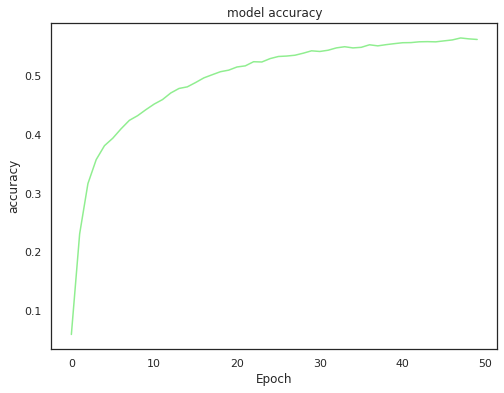

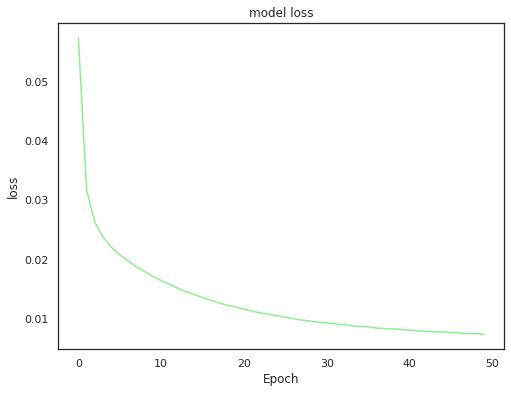

In [ ]:
# Train the optimal CNN model on training set
hist = model.fit(X_train, y_train, epochs=50)

for i in ["accuracy", "loss"]:
  plt.plot(hist.history[i])
  plt.title(f"model {i}")
  plt.ylabel(f"{i}")
  plt.xlabel("Epoch")
  plt.show()

In [ ]:
# Model performance on test data
model_eval = model.evaluate(X_test, y_test)
print(f"Test loss: {model_eval[0]}")
print(f"Test accuracy: {model_eval[1]}")

436/436 [==============================] - 1s 2ms/step - loss: 0.0481 - accuracy: 0.3094
Test loss: 0.04807529225945473
Test accuracy: 0.30940255522727966


In [ ]:
model_=[]
acc_=[]
time_=[]

model_.append('CNN_Title')
acc_.append(round(model_eval[1],3))
time_.append(round(elapsed/60,0))

df = pd.DataFrame()
df['Model'], df['Accuracy'], df['Time(min)'] = model_, acc_, time_
df

,Model,Accuracy,Time(min)
0,CNN_Title,0.309,21.0


### III.2. Word embedding (Deep learning) trained on Body

In [ ]:
# Clean data
mydata['text_clean'] = mydata['Body'].apply(lambda x: gensim.utils.simple_preprocess(x))

## Text encoding
def process_text(data):
    tokenizer = Tokenizer(num_words=5000, oov_token='<UNK>') # Tokenize text
    tokenizer.fit_on_texts(data)

    word_index = tokenizer.word_index # get word index
    vocab_size = len(tokenizer.word_index) + 1 # get the length of the vocabulary 

    sequences = tokenizer.texts_to_sequences(data) # Encode text into sequences
    maxlen = max([len(x) for x in sequences]) # Get the maximun lenth of sequence
    
    padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=maxlen) # Pad the sequences to the same lenth
    return word_index, sequences, maxlen, padded, vocab_size

text_processed = process_text(list(mydata['text_clean']))

## Print result of text encoding
print(f"- Shape : {text_processed[3].shape}")
print(f"- Maximum lenth of sequence : {text_processed[2]}")
print(f"- Vocabulary size : {text_processed[4]}")
print(f"- Type of sequences : {type(text_processed[1])}")
print(f"- Padding type : {type(text_processed[3])}")

print(f"- Word index of a sequence :\n{list(mydata['text_clean'])[0]}")
print(f"{text_processed[1][0]}")
print(f"- Padded text of the same sequence:\n{text_processed[3][0]}\n")

- Shape : (46476, 6491)
- Maximum lenth of sequence : 6491
- Vocabulary size : 205847
- Type of sequences : <class 'list'>
- Padding type : <class 'numpy.ndarray'>
- Word index of a sequence :
['migrating', 'project', 'code', 'microsoft', 'aspnetcore', 'mvc', 'newtonsoftjson', 'code', 'code', 'system', 'text', 'json', 'code', 'net', 'core', 'due', 'href', 'https', 'github', 'com', 'dotnet', 'runtime', 'pull', 'rel', 'nofollow', 'noreferrer', 'dotnet', 'runtime', 'models', 'contain', 'properties', 'type', 'code', 'idictionary', 'lt', 'int', 'gt', 'code', 'something', 'like', 'pre', 'class', 'lang', 'cs', 'prettyprint', 'override', 'code', 'public', 'class', 'myclass', 'public', 'int', 'id', 'set', 'public', 'idictionary', 'lt', 'int', 'thingclass', 'gt', 'things', 'set', 'code', 'pre', 'net', 'works', 'serialisation', 'works', 'pre', 'class', 'lang', 'cs', 'prettyprint', 'override', 'code', 'httpget', 'quot', 'id', 'quot', 'public', 'async', 'task', 'lt', 'myclass', 'gt', 'int', 'id', '

In [ ]:
# Define X
X = text_processed[3]

# Define Y 
Tags = mydata['Common_tags']
mlb = MultiLabelBinarizer() # Converting the multi-label classification to a binary output
Y = mlb.fit_transform(Tags)

print(X.shape)
print(Y.shape)

(46476, 6491)
(46476, 200)


In [ ]:
# Split data into train and test sets
stratifier = IterativeStratification(n_splits=2, order=2, 
                                     sample_distribution_per_fold=[1.0 - 0.7, 0.7]) # this class is a generator that produces
                                                                                    # k-folds. we just want to iterate it 
                                                                                    # once to make a single static split
                                                                                    # NOTE: needs to be computed on hard labels.

train_indexes, test_indexes = next(stratifier.split(X=X, y=Y))

# text array shape (N_samp,)
X_train, X_test = X[train_indexes], X[test_indexes]

# labels array shape (N_samp, n_classes)
y_train, y_test = Y[train_indexes, :], Y[test_indexes, :]


print('x_train', X_train.shape,'\n', 'y_train', y_train.shape, '\n')
print('x_test', X_test.shape, '\n' , 'y_test', y_test.shape)

x_train (32533, 6491) 
 y_train (32533, 200) 

x_test (13943, 6491) 
 y_test (13943, 200)


In [ ]:
## Define CNN model
start_time = timeit.default_timer()

maxlen = text_processed[2]
vocab_size = text_processed[4]

def create_model(num_filters, kernel_size, rate, units, lr, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate)) 
    model.add(Flatten())
    model.add(Dense(units, activation='relu'))
    model.add(Dense(200, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy']) 
    return model

## Model hyperparameters
param_grid = dict(num_filters=[128],
                  kernel_size=[5],
                  units=[32, 64],
                  vocab_size=[vocab_size], 
                  embedding_dim=[50, 100],
                  maxlen=[maxlen],
                  epochs = [20], 
                  batch_size = [20], 
                  lr = [0.001], 
                  rate = [0.0, 0.3])

## Hyperparameters tuning
model = KerasClassifier(build_fn=create_model, verbose=1)

grid_param = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=1, verbose=1) 
stop_early = EarlyStopping(monitor='accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

grid_result = grid_param.fit(X_train, y_train, callbacks=[stop_early])


# Best hyperparameters and Best model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

best_params = grid_result.best_params_
best_score = grid_result.best_score_
print(f"\nBest accuracy: {best_score} using these hyperparameters {grid_result.best_params_}\n")


model = create_model(num_filters=best_params['num_filters'],
                     kernel_size=best_params['kernel_size'],
                     rate=best_params['rate'],
                     units=best_params['units'],
                     lr=best_params['lr'],
                     vocab_size=best_params['vocab_size'],
                     embedding_dim=best_params['embedding_dim'],
                     maxlen=best_params['maxlen'])
model.summary()


elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/20
814/814 [==============================] - 22s 26ms/step - loss: 0.0701 - accuracy: 0.0534
Epoch 2/20
814/814 [==============================] - 21s 25ms/step - loss: 0.0400 - accuracy: 0.0848
Epoch 3/20
814/814 [==============================] - 21s 25ms/step - loss: 0.0341 - accuracy: 0.2059
Epoch 4/20
814/814 [==============================] - 21s 25ms/step - loss: 0.0288 - accuracy: 0.3011
Epoch 5/20
814/814 [==============================] - 21s 26ms/step - loss: 0.0248 - accuracy: 0.3654
Epoch 6/20
814/814 [==============================] - 21s 26ms/step - loss: 0.0218 - accuracy: 0.4155
Epoch 7/20
814/814 [==============================] - 21s 26ms/step - loss: 0.0194 - accuracy: 0.4510
Epoch 8/20
814/814 [==============================] - 21s 26ms/step - loss: 0.0174 - accuracy: 0.4810
Epoch 9/20
814/814 [==============================] - 21s 26ms/step - loss: 0.0156 - accuracy: 0.5085
Epoch 10/20
814/814 [==============================] - 21s 26ms/step - loss: 0.014

Epoch 1/50
1017/1017 [==============================] - 54s 53ms/step - loss: 0.0576 - accuracy: 0.0534
Epoch 2/50
1017/1017 [==============================] - 53s 53ms/step - loss: 0.0341 - accuracy: 0.1692
Epoch 3/50
1017/1017 [==============================] - 53s 52ms/step - loss: 0.0278 - accuracy: 0.2766
Epoch 4/50
1017/1017 [==============================] - 53s 52ms/step - loss: 0.0236 - accuracy: 0.3424
Epoch 5/50
1017/1017 [==============================] - 53s 52ms/step - loss: 0.0212 - accuracy: 0.3811
Epoch 6/50
1017/1017 [==============================] - 53s 52ms/step - loss: 0.0195 - accuracy: 0.4071
Epoch 7/50
1017/1017 [==============================] - 53s 52ms/step - loss: 0.0182 - accuracy: 0.4269
Epoch 8/50
1017/1017 [==============================] - 53s 52ms/step - loss: 0.0171 - accuracy: 0.4412
Epoch 9/50
1017/1017 [==============================] - 53s 52ms/step - loss: 0.0162 - accuracy: 0.4544
Epoch 10/50
1017/1017 [==============================] - 53s 52m

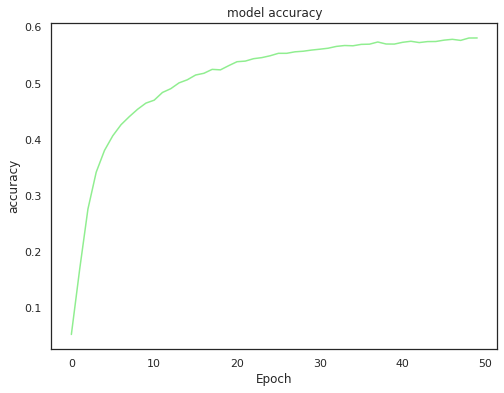

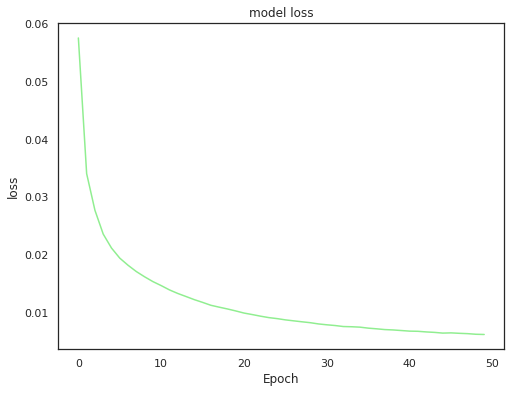

In [ ]:
# Train the optimal CNN model on training set
hist = model.fit(X_train, y_train, epochs=50)

for i in ["accuracy", "loss"]:
  plt.plot(hist.history[i])
  plt.title(f"model {i}")
  plt.ylabel(f"{i}")
  plt.xlabel("Epoch")
  plt.show()

In [ ]:
# Model performance on test data
model_eval = model.evaluate(X_test, y_test)
print(f"Test loss: {model_eval[0]}")
print(f"Test accuracy: {model_eval[1]}")

436/436 [==============================] - 7s 15ms/step - loss: 0.0300 - accuracy: 0.3941
Test loss: 0.030028576031327248
Test accuracy: 0.39410457015037537


In [ ]:
# Save model
model.save('/content/drive/My Drive/P7_POC/cnn_model_body.h5')

In [ ]:
model_.append('CNN_Body')
acc_.append(round(model_eval[1],3))
time_.append(round(elapsed/60,0))

df = pd.DataFrame()
df['Model'], df['Accuracy'], df['Time(min)'] = model_, acc_, time_
df

,Model,Accuracy,Time(min)
0,CNN_Title,0.309,21.0
1,CNN_Body,0.394,170.0


### III.3. Word embedding (Deep learning) trained on Title + Body

In [ ]:
# Clean data
mydata['text_clean'] = mydata['Title_Body'].apply(lambda x: gensim.utils.simple_preprocess(x))

## Text encoding
def process_text(data):
    tokenizer = Tokenizer(num_words=5000, oov_token='<UNK>') # Tokenize text
    tokenizer.fit_on_texts(data)

    word_index = tokenizer.word_index # get word index
    vocab_size = len(tokenizer.word_index) + 1 # get the length of the vocabulary 

    sequences = tokenizer.texts_to_sequences(data) # Encode text into sequences
    maxlen = max([len(x) for x in sequences]) # Get the maximun lenth of sequence
    
    padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=maxlen) # Pad the sequences to the same lenth
    return word_index, sequences, maxlen, padded, vocab_size

text_processed = process_text(list(mydata['text_clean']))

## Print result of text encoding
print(f"- Shape : {text_processed[3].shape}")
print(f"- Maximum lenth of sequence : {text_processed[2]}")
print(f"- Vocabulary size : {text_processed[4]}")
print(f"- Type of sequences : {type(text_processed[1])}")
print(f"- Padding type : {type(text_processed[3])}\n")

print(f"- Word index of a sequence :\n{list(mydata['text_clean'])[0]}")
print(f"{text_processed[1][0]}")
print(f"- Padded text of the same sequence:\n{text_processed[3][0]}")

- Shape : (46476, 6496)
- Maximum lenth of sequence : 6496
- Vocabulary size : 207177
- Type of sequences : <class 'list'>
- Padding type : <class 'numpy.ndarray'>

- Word index of a sequence :
['net', 'system', 'text', 'json', 'configure', 'frombody', 'avoid', 'deserialisation', 'error', 'non', 'string', 'dictionary', 'key', 'migrating', 'project', 'code', 'microsoft', 'aspnetcore', 'mvc', 'newtonsoftjson', 'code', 'code', 'system', 'text', 'json', 'code', 'net', 'core', 'due', 'href', 'https', 'github', 'com', 'dotnet', 'runtime', 'pull', 'rel', 'nofollow', 'noreferrer', 'dotnet', 'runtime', 'models', 'contain', 'properties', 'type', 'code', 'idictionary', 'lt', 'int', 'gt', 'code', 'something', 'like', 'pre', 'class', 'lang', 'cs', 'prettyprint', 'override', 'code', 'public', 'class', 'myclass', 'public', 'int', 'id', 'set', 'public', 'idictionary', 'lt', 'int', 'thingclass', 'gt', 'things', 'set', 'code', 'pre', 'net', 'works', 'serialisation', 'works', 'pre', 'class', 'lang', 'cs'

In [ ]:
# Define X
X = text_processed[3]

# Define Y 
Tags = mydata['Common_tags']
mlb = MultiLabelBinarizer() # Converting the multi-label classification to a binary output
Y = mlb.fit_transform(Tags)

print(X.shape)
print(Y.shape)

(46476, 6496)
(46476, 200)


In [ ]:
# Split data into train and test sets
stratifier = IterativeStratification(n_splits=2, order=2, 
                                     sample_distribution_per_fold=[1.0 - 0.7, 0.7]) # this class is a generator that produces
                                                                                    # k-folds. we just want to iterate it 
                                                                                    # once to make a single static split
                                                                                    # NOTE: needs to be computed on hard labels.

train_indexes, test_indexes = next(stratifier.split(X=X, y=Y))

# text array shape (N_samp,)
X_train, X_test = X[train_indexes], X[test_indexes]

# labels array shape (N_samp, n_classes)
y_train, y_test = Y[train_indexes, :], Y[test_indexes, :]


print('x_train', X_train.shape,'\n', 'y_train', y_train.shape, '\n')
print('x_test', X_test.shape, '\n' , 'y_test', y_test.shape)

x_train (32533, 6496) 
 y_train (32533, 200) 

x_test (13943, 6496) 
 y_test (13943, 200)


In [ ]:
## Define CNN model
start_time = timeit.default_timer()

maxlen = text_processed[2]
vocab_size = text_processed[4]

def create_model(num_filters, kernel_size, rate, units, lr, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate)) 
    model.add(Flatten())
    model.add(Dense(units, activation='relu'))
    model.add(Dense(200, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy']) 
    return model

## Model hyperparameters
param_grid = dict(num_filters=[128],
                  kernel_size=[5],
                  units=[32, 64],
                  vocab_size=[vocab_size], 
                  embedding_dim=[50, 100],
                  maxlen=[maxlen],
                  epochs = [20], 
                  batch_size = [20], 
                  lr = [0.001], 
                  rate = [0.0, 0.3])

## Hyperparameters tuning
model = KerasClassifier(build_fn=create_model, verbose=1)

grid_param = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=1, verbose=1) 
stop_early = EarlyStopping(monitor='accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

grid_result = grid_param.fit(X_train, y_train, callbacks=[stop_early])


# Best hyperparameters and Best model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

best_params = grid_result.best_params_
best_score = grid_result.best_score_
print(f"\nBest accuracy: {best_score} using these hyperparameters {grid_result.best_params_}\n")


model = create_model(num_filters=best_params['num_filters'],
                     kernel_size=best_params['kernel_size'],
                     rate=best_params['rate'],
                     units=best_params['units'],
                     lr=best_params['lr'],
                     vocab_size=best_params['vocab_size'],
                     embedding_dim=best_params['embedding_dim'],
                     maxlen=best_params['maxlen'])
model.summary()


elapsed = timeit.default_timer() - start_time
print(f"Time: {round(elapsed/60,0)} min")

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/20
814/814 [==============================] - 32s 25ms/step - loss: 0.0697 - accuracy: 0.0500
Epoch 2/20
814/814 [==============================] - 21s 25ms/step - loss: 0.0413 - accuracy: 0.0770
Epoch 3/20
814/814 [==============================] - 21s 25ms/step - loss: 0.0346 - accuracy: 0.2085
Epoch 4/20
814/814 [==============================] - 21s 25ms/step - loss: 0.0278 - accuracy: 0.3161
Epoch 5/20
814/814 [==============================] - 21s 26ms/step - loss: 0.0234 - accuracy: 0.3965
Epoch 6/20
814/814 [==============================] - 21s 26ms/step - loss: 0.0203 - accuracy: 0.4424
Epoch 7/20
814/814 [==============================] - 21s 26ms/step - loss: 0.0179 - accuracy: 0.4825
Epoch 8/20
814/814 [==============================] - 21s 26ms/step - loss: 0.0160 - accuracy: 0.5126
Epoch 9/20
814/814 [==============================] - 21s 26ms/step - loss: 0.0143 - accuracy: 0.5357
Epoch 10/20
814/814 [==============================] - 21s 26ms/step - loss: 0.012

Epoch 1/50
1017/1017 [==============================] - 55s 53ms/step - loss: 0.0575 - accuracy: 0.0591
Epoch 2/50
1017/1017 [==============================] - 54s 53ms/step - loss: 0.0334 - accuracy: 0.1846
Epoch 3/50
1017/1017 [==============================] - 54s 53ms/step - loss: 0.0261 - accuracy: 0.3095
Epoch 4/50
1017/1017 [==============================] - 54s 53ms/step - loss: 0.0218 - accuracy: 0.3800
Epoch 5/50
1017/1017 [==============================] - 54s 53ms/step - loss: 0.0193 - accuracy: 0.4228
Epoch 6/50
1017/1017 [==============================] - 54s 53ms/step - loss: 0.0177 - accuracy: 0.4431
Epoch 7/50
1017/1017 [==============================] - 53s 53ms/step - loss: 0.0165 - accuracy: 0.4594
Epoch 8/50
1017/1017 [==============================] - 54s 53ms/step - loss: 0.0154 - accuracy: 0.4743
Epoch 9/50
1017/1017 [==============================] - 53s 53ms/step - loss: 0.0145 - accuracy: 0.4831
Epoch 10/50
1017/1017 [==============================] - 53s 52m

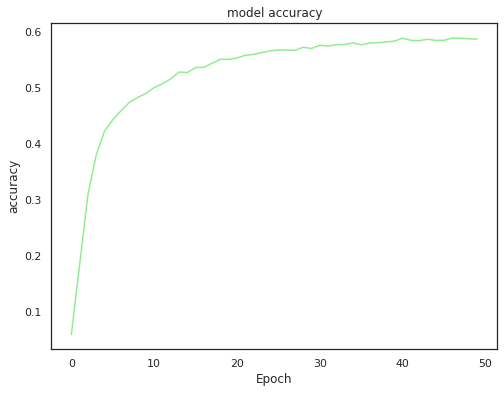

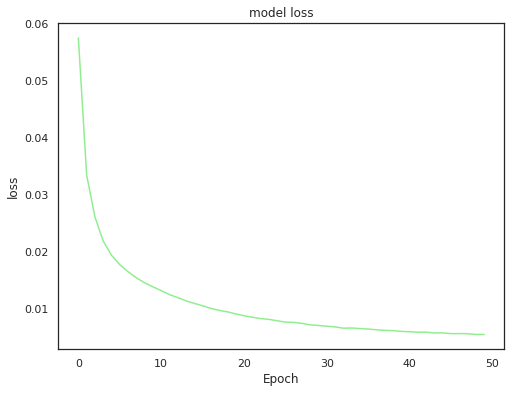

In [ ]:
# Train the optimal CNN model on training set
hist = model.fit(X_train, y_train, epochs=50)

for i in ["accuracy", "loss"]:
  plt.plot(hist.history[i])
  plt.title(f"model {i}")
  plt.ylabel(f"{i}")
  plt.xlabel("Epoch")
  plt.show()

In [ ]:
# Model performance on test data
model_eval = model.evaluate(X_test, y_test)
print(f"Test loss: {model_eval[0]}")
print(f"Test accuracy: {model_eval[1]}")

436/436 [==============================] - 5s 11ms/step - loss: 0.0251 - accuracy: 0.4155
Test loss: 0.02508573792874813
Test accuracy: 0.41554901003837585


In [ ]:
model_.append('CNN_Title&Body')
acc_.append(round(model_eval[1],3))
time_.append(round(elapsed/60,0))

df = pd.DataFrame()
df['Model'], df['Accuracy'], df['Time(min)'] = model_, acc_, time_
df

,Model,Accuracy,Time(min)
0,CNN_Title,0.309,21.0
1,CNN_Body,0.394,170.0
2,CNN_Title&Body,0.415,161.0


### III.4. Word embedding (Deep learning) trained on Title + Body and tested on a new set of Title

In [ ]:
# Import new dataset

# Import Datasets
path = "/content/drive/My Drive/P7_POC/QueryResults_for_test.csv"
data_stackoverflow = pd.read_csv(path, low_memory=False, encoding='latin-1')

data_stackoverflow = data_stackoverflow[data_stackoverflow['ViewCount']>=30]

df_sample = data_stackoverflow.iloc[:,[-5, -6]].reset_index().drop(['index'], axis=1)
df_sample.head()

,Tags,Title
0,<node.js><sapui5><puppeteer><karma-runner>,How can I get puppeteer objects from within a ...
1,<jq>,Why is jq modify and if-then-else not working
2,<amazon-web-services><aws-lambda><aws-sdk><aws...,Remove a Layer from an AWS Lambda Function
3,<css><fonts><wkhtml2pdf>,How to use local system fonts with wkhtml2pdf ...
4,<sql><sql-server>,SQL Server and optimizing Common Table Expression


In [ ]:
# Remove punctuation
df_sample['Title'] = df_sample['Title'].map(lambda x: re.sub('[,\.!?]<>-', ' ', x))
df_sample['Tags'] = df_sample['Tags'].map(lambda x: re.sub('[<>]', ' ', x))

stop_words = stopwords.words('english')
stop_words.extend(['from', 'without', 'way', 'subject', 're', 'edu', 'be', 'have', 'do', 'say', 
                   'get', 'make', 'go', 'know', 'take', 'see', 'come', 'think', 
                   'look', 'want', 'give', 'use', 'find', 'tell', 'ask', 'work',
                   'seem', 'feel', 'try', 'leave', 'call'])

# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(df_sample['Title'])

# Data shaping for the analysis
Texts = []
for i in data_words_nostops:
    Texts.append(' '.join(map(str, i)))

# Create the data on which I will do the analysis
mydata = pd.DataFrame()

mydata['Title'], mydata['Tags'] = Texts, df_sample['Tags']
mydata

,Title,Tags
0,puppeteer objects within test,node.js sapui5 puppeteer karma-runner
1,jq modify else working,jq
2,remove layer aws lambda function,amazon-web-services aws-lambda aws-sdk aws...
3,local system fonts wkhtml pdf pre tags,css fonts wkhtml2pdf
4,sql server optimizing common table expression,sql sql-server
...,...,...
21639,python regex set options occur list order,python regex perl
21640,store public certificates truststore,java spring-boot ssl ssl-certificate cace...
21641,write glob pattern,python glob
21642,nan raise errors python,python


In [ ]:
# Extract the 200 most frequent tags

mydata['Tags_list'] = mydata.Tags.apply(lambda x: x[:].split(' '))# Convert the text in tags into a list of words
Most_freq = pd.Series(' '.join(mydata['Tags']).split()).value_counts()[:200].index # Select the 200 most frequent words in tags

# Add the 200 most frequent tags to all the row of mydata
Most_freq_tags=[]
for i in range(0, len(Most_freq)):
    Most_freq_tags.append(Most_freq[i])
mydata['Most_freq_tags'] = pd.Series([Most_freq_tags for x in range(len(mydata.index))]) # Add the list to all the row

common_tags = []
for i in range(0,len(mydata)):
    List_tags = mydata['Tags_list'][i]
    Frequent_tags = mydata['Most_freq_tags'][i]
    common_tags.append([x for x in Frequent_tags if x in List_tags])
mydata['Common_tags'] = common_tags # Add the Common_tags to mydata


# Convert the list of Common tags into Text
Tags_final = []

for i in mydata['Common_tags']:
    Tags_final.append(' '.join(map(str, i)))
mydata['Tags_final'] = Tags_final


# Columns selection for modeling
mydata = mydata.loc[:, ['Title', 'Common_tags', 'Tags_final']]

# Clean data
mydata['text_clean'] = mydata['Title'].apply(lambda x: gensim.utils.simple_preprocess(x))
mydata.head()

,Title,Common_tags,Tags_final,text_clean
0,puppeteer objects within test,[node.js],node.js,"[puppeteer, objects, within, test]"
1,jq modify else working,[],,"[jq, modify, else, working]"
2,remove layer aws lambda function,"[amazon-web-services, aws-lambda]",amazon-web-services aws-lambda,"[remove, layer, aws, lambda, function]"
3,local system fonts wkhtml pdf pre tags,[css],css,"[local, system, fonts, wkhtml, pdf, pre, tags]"
4,sql server optimizing common table expression,"[sql, sql-server]",sql sql-server,"[sql, server, optimizing, common, table, expre..."


In [ ]:
# Text encoding
def process_text(data):
    
    tokenizer = Tokenizer(num_words=5000, oov_token='<UNK>')
    tokenizer.fit_on_texts(data)

    word_index = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1

    sequences = tokenizer.texts_to_sequences(data)

    # maxlen should be equal to the training set
    #maxlen = max([len(x) for x in sequences])

    padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=maxlen)

    return word_index, sequences, maxlen, padded, vocab_size

messages = process_text(list(mydata['text_clean']))

# Define X_new
maxlen = maxlen
vocab_size = messages[4]
X_new = messages[3]
print(X_new.shape)

# Define Y_new
Tags = mydata['Common_tags']
mlb = MultiLabelBinarizer() # Converting the multi-label classification to a binary output
y_new = mlb.fit_transform(Tags)
print(y_new.shape)

(21644, 6496)
(21644, 200)


In [ ]:
# Split data into train and test sets
stratifier = IterativeStratification(n_splits=2, order=2, 
                                     sample_distribution_per_fold=[1.0 - 0.8, 0.8])

train_indexes, test_indexes = next(stratifier.split(X=X_new, y=y_new))

# text array shape (N_samp,)
X_train_new, X_test_new = X[train_indexes], X[test_indexes]

# labels array shape (N_samp, n_classes)
y_train_new, y_test_new = Y[train_indexes, :], Y[test_indexes, :]

print('x_train_new', X_train_new.shape,'\n', 'y_train_new', y_train_new.shape, '\n')
print('x_test_new', X_test_new.shape, '\n' , 'y_test_new', y_test_new.shape)

x_train_new (17315, 6496) 
 y_train_new (17315, 200) 

x_test_new (4329, 6496) 
 y_test_new (4329, 200)


In [ ]:
# Model performance on new data
model_eval = model.evaluate(X_train_new, y_train_new)
print(f"Test loss: {model_eval[0]}")
print(f"Test accuracy: {model_eval[1]}")

542/542 [==============================] - 6s 11ms/step - loss: 0.0132 - accuracy: 0.5097
Test loss: 0.013152280822396278
Test accuracy: 0.5096737146377563


In [ ]:
model_.append('CNN_Title&Body/test_Title')
acc_.append(round(model_eval[1],3))
time_.append(161) # as the one before. It's the same training 

df = pd.DataFrame()
df['Model'], df['Accuracy'], df['Time(min)'] = model_, acc_, time_
df

,Model,Accuracy,Time(min)
0,CNN_Title,0.309,21.0
1,CNN_Body,0.394,170.0
2,CNN_Title&Body,0.415,161.0
3,CNN_Title&Body/test_Title,0.510,161.0


### II.5. Figure showing the performance in terms of time and accuracy of each of the SGDClassifier models

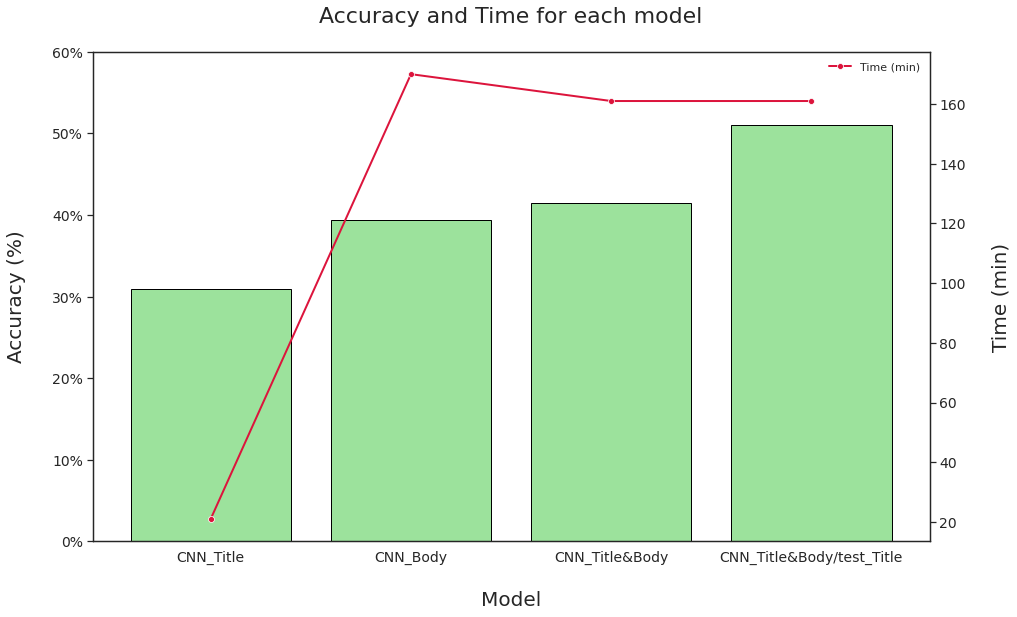

In [ ]:
plt.figure(figsize=(15, 9))
sns.set_theme(style="white")

x_ = df.columns[0]
y_ = df.columns[1]
y_2 = df.columns[2]
data1 = df[[x_, y_]]
data2 = df[[x_, y_2]]

ax = sns.barplot(x=x_, y=y_, data=data1, edgecolor="black", color='lightgreen')
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_ylim([0,0.6])
ax.set_xlabel("\nModel", fontsize=20)
ax.set_ylabel("Accuracy (%)\n", fontsize=20)
ax.set_title("Accuracy and Time for each model\n", fontsize=22)

ax2 = ax.twinx()
p = sns.lineplot(x=x_, y=y_2, data=data2, marker='o', color='crimson', lw=2, ax=ax2)
#p.set_ylim([0,30])
p.tick_params(axis = 'both', labelsize = 14)
p.set_ylabel("\nTime (min)", fontsize=20)

plt.legend(labels=["Time (min)"], loc = 1)
